In [1]:
# Load Libreries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

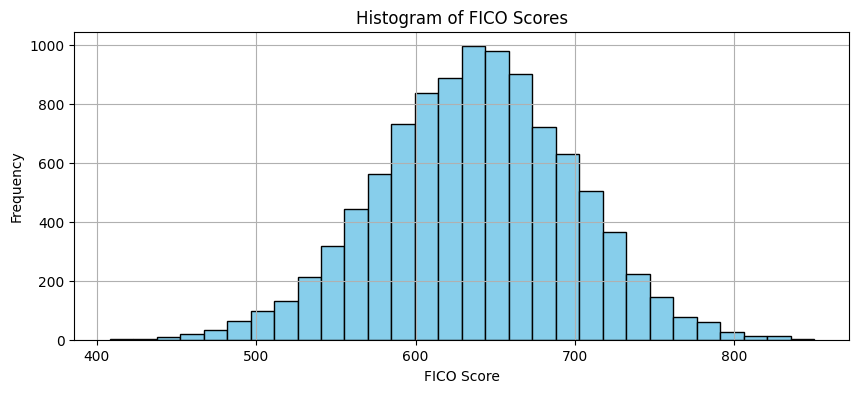

In [2]:
# Visial data
data = pd.read_csv('loan_Data.csv')
fico_scores = data['fico_score'].dropna().values

# Plotting the histogram
plt.figure(figsize=(10,4))
plt.hist(fico_scores, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('FICO Score')
plt.ylabel('Frequency')
plt.title('Histogram of FICO Scores')
plt.grid(True)
plt.show()


1. Use MSE to find optimized boundaries for buckets.

In [3]:
def mse(start, end, cum_sum, cum_sq_sum):
    """ Compute the MSE for scores[start:end] using precomputed cumulative sums """
    if start >= end:
        return 0
    count = end - start
    total_sum = cum_sum[end] - cum_sum[start]
    total_sq_sum = cum_sq_sum[end] - cum_sq_sum[start]
    mean = total_sum / count
    total_var = (total_sq_sum - 2 * mean * total_sum + count * mean ** 2)
    return total_var / count

def calculate_dp_buckets_mse(scores, K):
    n = len(scores)
    scores = np.sort(scores)
    dp = np.zeros((n + 1, K ))
    parent = np.zeros((n + 1, K ), dtype=int)
    
    # Cumulative sums and cumulative sums of squares
    cum_sum = np.cumsum(np.insert(scores, 0, 0))
    cum_sq_sum = np.cumsum(np.insert(scores ** 2, 0, 0))
    
    # Initialize DP arrays
    for i in range(1, n + 1):
        dp[i][1] = mse(0, i, cum_sum, cum_sq_sum)
    
    # Dynamic programming to fill the table
    for k in range(2, K ):
        for i in range(1, n + 1):
            dp[i][k] = float('inf')
            for j in range(0, i):
                cost = mse(j, i, cum_sum, cum_sq_sum)
                if dp[j][k - 1] + cost < dp[i][k]:
                    dp[i][k] = dp[j][k - 1] + cost
                    parent[i][k] = j

    # Recover the boundaries from the DP table
    boundaries = [n]
    cur = n
    for k in range(K-1, 0, -1):
        cur = parent[cur][k]
        boundaries.append(cur)
    
    boundaries = sorted(set(boundaries))  # Remove duplicates and sort
    return scores[boundaries[:-1]]

In [4]:
def assign_ratings(fico_scores, bucket_boundaries):
    """ Assign ratings based on bucket boundaries"""
    ratings = np.digitize(fico_scores, bucket_boundaries, right=True)
    return 10 - ratings

In [5]:
K = 10  # Number of buckets
bucket_boundaries = calculate_dp_buckets_mse(fico_scores, K)
print("Bucket boundaries:", bucket_boundaries)

Bucket boundaries: [408 510 547 589 625 661 696 730 768]


In [6]:
bucket_boundaries_mse = np.insert(bucket_boundaries, 0, 300)
bucket_boundaries_mse = np.append(bucket_boundaries, 850)

In [7]:
# Add rating to data
data['rating_mse'] = assign_ratings(data['fico_score'], bucket_boundaries_mse)
print(data[['fico_score', 'rating_mse']].head())

   fico_score  rating_mse
0         605           6
1         572           7
2         602           6
3         612           6
4         631           5


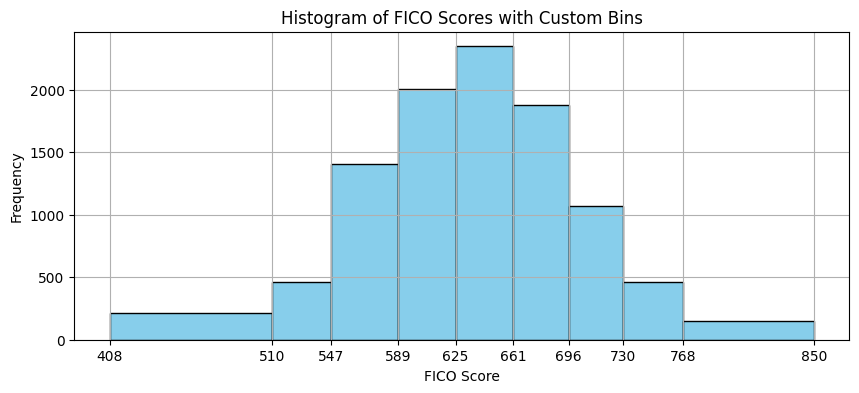

In [8]:
# Visual buckets
# Plotting the histogram with custom bins
hist, bins = np.histogram(fico_scores, bins=bucket_boundaries_mse)

plt.figure(figsize=(10,4))
plt.hist(fico_scores, bins=bucket_boundaries_mse, color='skyblue', edgecolor='black')
plt.xlabel('FICO Score')
plt.ylabel('Frequency')
plt.title('Histogram of FICO Scores with Custom Bins')
plt.xticks(bucket_boundaries_mse)  # Set x-axis ticks to match bin boundaries
plt.grid(True)
plt.show()

2. Use Log-likelihood to find boundaries.

In [9]:
def log_likelihood(ki, ni):
    """ Calculate the log-likelihood for a bucket"""
    if ki == 0:
        log_pi = 0  # log(0) scenario avoided as pi would be 0
        log_one_minus_pi = np.log(1 - 1e-10)  # log(1) nearly zero
    elif ki == ni:
        log_pi = np.log(1 - 1e-10)  # log(1) nearly zero
        log_one_minus_pi = 0  # log(0) scenario avoided as pi would be 1
    else:
        pi = ki / ni
        log_pi = np.log(pi)
        log_one_minus_pi = np.log(1 - pi)
        
    return ki * log_pi + (ni - ki) * log_one_minus_pi

def calculate_dp_buckets_ll(data, K):
    scores = data['fico_score'].values
    defaults = data['default'].values
    n = len(scores)

    # Sort data by scores
    idx = np.argsort(scores)
    scores = scores[idx]
    defaults = defaults[idx]

    # Dynamic programming arrays
    dp = np.zeros((n + 1, K + 1))
    parent = np.zeros((n + 1, K + 1), dtype=int)

    # Cumulative sums for defaults and counts
    cum_defaults = np.cumsum(np.insert(defaults, 0, 0))
    cum_counts = np.arange(n + 1)

    # Initialize dp for k = 1
    for i in range(1, n + 1):
        dp[i][1] = log_likelihood(cum_defaults[i], cum_counts[i])
    
    # Fill dp table
    for k in range(2, K + 1):
        for i in range(1, n + 1):
            dp[i][k] = float('-inf')
            for j in range(0, i):
                ki = cum_defaults[i] - cum_defaults[j]
                ni = cum_counts[i] - cum_counts[j]
                likelihood = log_likelihood(ki, ni)
                if dp[j][k - 1] + likelihood > dp[i][k]:
                    dp[i][k] = dp[j][k - 1] + likelihood
                    parent[i][k] = j

    # Recover the boundaries from the DP table
    boundaries = []
    cur = n
    k = K
    while k > 0:
        boundaries.append(parent[cur][k])
        cur = parent[cur][k]
        k -= 1

    boundaries = sorted(set(boundaries))
    return scores[boundaries]

In [10]:
K = 10  # Number of buckets
bucket_boundaries = calculate_dp_buckets_ll(data, K)
print("Bucket boundaries:", bucket_boundaries)

Bucket boundaries: [408 502 553 580 608 608 648 649 696 732]


In [11]:
bucket_boundaries_ll = np.insert(bucket_boundaries, 0, 300)
bucket_boundaries_ll = np.append(bucket_boundaries, 850)

In [12]:
# Add rating to data
data['rating_ll'] = assign_ratings(data['fico_score'], bucket_boundaries_ll)
print(data[['fico_score', 'rating_mse','rating_ll']].head())

   fico_score  rating_mse  rating_ll
0         605           6          6
1         572           7          7
2         602           6          6
3         612           6          4
4         631           5          4


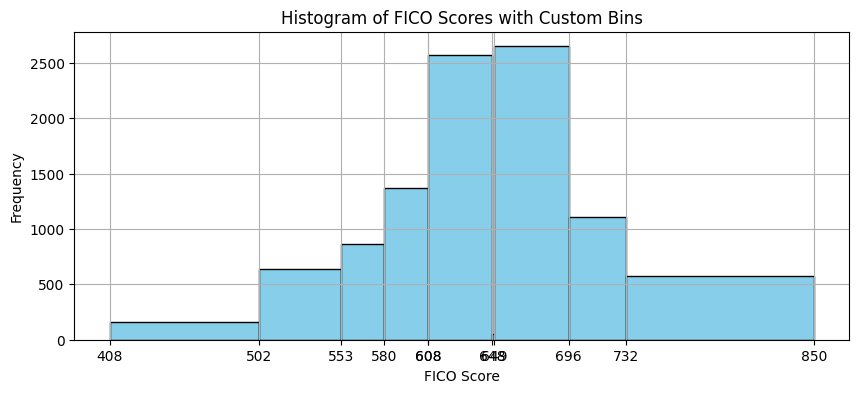

In [13]:
# Visual buckets
# Plotting the histogram with custom bins
hist, bins = np.histogram(fico_scores, bins=bucket_boundaries_ll)

plt.figure(figsize=(10,4))
plt.hist(fico_scores, bins=bucket_boundaries_ll, color='skyblue', edgecolor='black')
plt.xlabel('FICO Score')
plt.ylabel('Frequency')
plt.title('Histogram of FICO Scores with Custom Bins')
plt.xticks(bucket_boundaries_ll)  # Set x-axis ticks to match bin boundaries
plt.grid(True)
plt.show()